In [46]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
cudnn.benchmark = True
from PIL import Image
import cv2
plt.ion() 

## Preprocesar los datos por etiqueta

In [70]:
df=pd.read_csv("WormData.csv")
train=df.sample(frac=0.8)

In [81]:
def save_data(dataset,kind):
    df=pd.read_csv(dataset)
    train=df.sample(frac=0.8)
    test=df.sample(frac=0.2)
    train.reset_index(drop=True, inplace=True)
    test.reset_index(drop=True, inplace=True)
    if kind=="train":
        pathf="train"
        dataset=train
    elif kind=="test":
        dataset=test
        pathf="val"
    else:
        print("Solo puedes poner las opciones train y val")
    ds=dataset
    for i in range(len(ds)):
        img =cv2.imread("WormImages/"+ds.at[i,"File"],0)
        img=cv2.equalizeHist(img)
        if ds.at[i,"Status"]=="alive":
            cv2.imwrite("worms/"+pathf+"/alive/"+str("img")+str(i)+str(pathf)+".jpg",img)
        elif ds.at[i,"Status"]=="dead":
            cv2.imwrite("worms/"+pathf+"/dead/"+str("img")+str(i)+str(pathf)+".jpg",img)
    return

In [83]:
save_data("WormData.csv", "train")

In [84]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [85]:
data_dir = 'worms/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

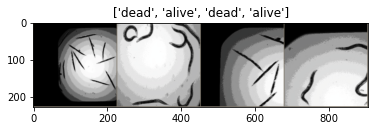

In [87]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [88]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [100]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2,2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [90]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/isaac/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [97]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=8)

Epoch 0/7
----------
train Loss: 0.3951 Acc: 0.8649
val Loss: 0.0353 Acc: 1.0000

Epoch 1/7
----------
train Loss: 0.2847 Acc: 0.8649
val Loss: 0.0459 Acc: 1.0000

Epoch 2/7
----------
train Loss: 0.4014 Acc: 0.8378
val Loss: 0.0372 Acc: 1.0000

Epoch 3/7
----------
train Loss: 0.5177 Acc: 0.7838
val Loss: 0.0479 Acc: 1.0000

Epoch 4/7
----------
train Loss: 0.4701 Acc: 0.8243
val Loss: 0.0460 Acc: 1.0000

Epoch 5/7
----------
train Loss: 0.2766 Acc: 0.8784
val Loss: 0.0274 Acc: 1.0000

Epoch 6/7
----------
train Loss: 0.4021 Acc: 0.7973
val Loss: 0.0447 Acc: 1.0000

Epoch 7/7
----------
train Loss: 0.2732 Acc: 0.8919
val Loss: 0.1051 Acc: 0.9286

Training complete in 0m 58s
Best val Acc: 1.000000


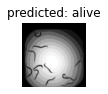

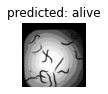

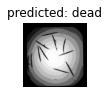

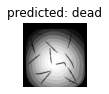

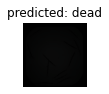

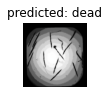

In [101]:
visualize_model(model_ft)

# Resnet 18

In [93]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [94]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7174 Acc: 0.5405
val Loss: 0.4859 Acc: 0.8571

Epoch 1/24
----------
train Loss: 0.3765 Acc: 0.8378
val Loss: 0.4660 Acc: 0.7857

Epoch 2/24
----------
train Loss: 0.2759 Acc: 0.9054
val Loss: 0.4118 Acc: 0.7500

Epoch 3/24
----------
train Loss: 0.1939 Acc: 0.9189
val Loss: 0.1682 Acc: 1.0000

Epoch 4/24
----------
train Loss: 0.3729 Acc: 0.7838
val Loss: 0.2053 Acc: 0.9643

Epoch 5/24
----------
train Loss: 0.2136 Acc: 0.9054
val Loss: 0.2635 Acc: 0.8214

Epoch 6/24
----------
train Loss: 0.4504 Acc: 0.7568
val Loss: 0.6268 Acc: 0.6071

Epoch 7/24
----------
train Loss: 0.7558 Acc: 0.7432
val Loss: 0.2111 Acc: 0.9286

Epoch 8/24
----------
train Loss: 0.2180 Acc: 0.8784
val Loss: 0.1161 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.2189 Acc: 0.8919
val Loss: 0.1409 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.2989 Acc: 0.8514
val Loss: 0.1574 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.2988 Acc: 0.8514
val Loss: 0.1459 Acc: 1.0000

Ep

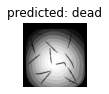

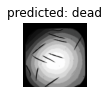

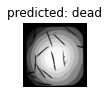

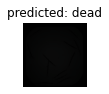

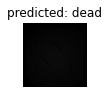

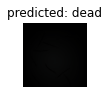

In [95]:
visualize_model(model_conv)

plt.ioff()
plt.show()